# **Project Code | PH3406 - Open Quantum Systems**
## **Quantum State Tomography of a Two-qubit System**
### *Oscar Stommendal, Spring 2025*

##### **Note on the source code** 
The foundation of the source code used in this project is taken from [Qiskit's](https://qiskit-c≈ommunity.github.io/qiskit-experiments/manuals/verification/state_tomography.html) experiment manual on Quantum State Tomography, with some minor adjustments made by me to achieve the goals of this project.

In [1]:

from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error

import qiskit
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams['text.latex.preamble'] = r'\usepackage{braket}'

# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True


In [152]:

def get_QST_state(Nq, noise=False, noise_choice='depol', output=False):
    ideal_backend = AerSimulator()

    # GHZ State preparation circuit 
    qc_ghz = qiskit.QuantumCircuit(Nq, Nq) # Create a quantum circuit with nq qubits
    qc_ghz.h(0) # Apply a Hadamard gate on the first qubit
    qc_ghz.s(0) # Apply a S gate on the first qubit
    for i in range(1, Nq):
        qc_ghz.cx(0, i) # Apply a CNOT gate between the first qubit and the others

    if output:
        backend = StatevectorSimulator()
        job = backend.run(qc_ghz)
        result = job.result()
        state = result.get_statevector(qc_ghz)
        display(Markdown('### Original state: '))
        display(state.draw('latex'))

        display(Markdown('### Original density matrix: '))
        display(get_density_matrix(state))

        return

    # Add noise if specified
    if noise:
        if noise_choice == 'depol':
            # Error probabilities
            prob_1 = 0.1  # 1-qubit gate
            prob_2 = 0.2   # 2-qubit gate

            # Depolarizing quantum errors
            error_1 = depolarizing_error(prob_1, 1)
            error_2 = depolarizing_error(prob_2, 2)

            # Add errors to noise model
            noise_model = NoiseModel()
            noise_model.add_all_qubit_quantum_error(error_1, ['h', 'sx'])
            noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

            noise_backend = AerSimulator(noise_model=noise_model)
            trans_qc = transpile(qc_ghz, noise_backend)
            print(noise_backend)

        elif noise_choice == 'meas':
            # Create a measurement error model with a given probability p
            probs = np.zeros((Nq, Nq))
            for i in range(0, Nq):
                for j in range(0, Nq):
                    if i == j:
                        probs[i, j] = 0.85
                    else:
                        probs[i, j] = 0.15

            readout_error = ReadoutError(probs)  # Apply error to all qubits
            
            # Add the readout error to the noise model
            noise_model = NoiseModel()
            noise_model.add_readout_error(readout_error, [0])
            noise_model.add_readout_error(readout_error, [1])
            
            # Use the noisy backend with the measurement error model
            noise_backend = AerSimulator(noise_model=noise_model)
            trans_qc = transpile(qc_ghz, noise_backend)
            
        return noise_backend, trans_qc  # Return the backend with noise and the circuit

    return ideal_backend, qc_ghz  # Return the ideal backend and the circuit if no noise

def get_QST_data(Ncounts, Nq, noise=False, noise_choice='device'):

    backend, state = get_QST_state(Nq, noise=noise, noise_choice=noise_choice)

    # state.measure([0, 1], [0, 1])
    # result = backend.run(state, shots=1000).result()

    # # Step 4: Plot the results
    # counts = result.get_counts()
    # print(counts)
    # plot_histogram(counts)
    # plt.show()

    qst = StateTomography(state)
    if noise:
        qst_data = qst.run(backend=backend, shots=Ncounts).block_for_results()
    else:
        qst_data = qst.run(backend=backend, shots=Ncounts).block_for_results()

    return qst_data

def plot_density_matrix(rho):
    n = len(rho)
    xpos, ypos = np.meshgrid(range(n), range(n))

    xpos = xpos.ravel()
    ypos = ypos.ravel()

    # Get real and imaginary parts
    real_part = np.real(rho).flatten()
    imag_part = np.imag(rho).flatten()

    # Phases (for coloring)
    phase_real = np.angle(real_part)
    phase_imag = np.angle(imag_part)

    # Colormap based on phase
    cmap = plt.get_cmap("twilight")

    fig = plt.figure(figsize=(14, 6))

    # Real part
    ax1 = fig.add_subplot(121, projection="3d")
    ax1.bar3d(
        xpos,
        ypos,
        np.zeros_like(real_part),
        0.8,
        0.8,
        real_part,
        color=cmap((phase_real + np.pi) / (2 * np.pi)),
    )
    ax1.set_title('Re($\\hat{\\rho}$)')

    # Imaginary part
    ax2 = fig.add_subplot(122, projection="3d")
    ax2.bar3d(
        xpos,
        ypos,
        np.zeros_like(imag_part),
        0.8,
        0.8,
        imag_part,
        color=cmap((phase_imag + np.pi) / (2 * np.pi)),
    )
    ax2.set_zlim(-0.5, 0.5)
    ax2.set_title('Im($\\hat{\\rho}$)')

    for ax in [ax1, ax2]:
        # Set xticks in the middle of the bars
        ax.set_xticks([0.4, 1.4, 2.4, 3.4])
        ax.set_yticks([0.4, 1.4, 2.4, 3.4])
        ax.set_xticklabels(['$\\ket{00}$', '$\\ket{01}$', '$\\ket{10}$', '$\\ket{11}$'])
        ax.set_yticklabels(['$\\bra{00}$', '$\\bra{01}$', '$\\bra{10}$', '$\\bra{11}$'])

    plt.tight_layout()
    plt.show()

def get_density_matrix(state):
    rho = np.outer(state, np.conj(state))

    return sp.Matrix(rho)

def save_data(data, Nq, noise, noise_choice):
    dens = np.array(data.analysis_results()[0].value)
    fid = data.analysis_results()[1].value
    extra = data.analysis_results("state").extra
    filename = f'data/QST_data_{noise_choice}_{noise}.csv'
    filename_dens = f'data/density_matrix_{noise_choice}_{noise}.csv'

    np.savetxt(filename_dens, dens, delimiter=',')
    with open(filename, 'w') as f:
        f.write(f'fidelity: {fid}\n')
        for key, value in extra.items():
            f.write(f'{key}: {value}\n')

def read_density_matrix(dens_filename):
    dens = np.loadtxt(dens_filename, delimiter=',', dtype=complex)
    
    return dens
    

In [153]:

get_QST_state(2, output=True)


### Original state: 

<IPython.core.display.Latex object>

### Original density matrix: 

Matrix([
[  0.5, 0, 0, -0.5*I],
[    0, 0, 0,      0],
[    0, 0, 0,      0],
[0.5*I, 0, 0,    0.5]])

In [ ]:

data_ideal = get_QST_data(1000, 2, noise=False)
save_data(data_ideal, 2, False, 'ideal')

data_noise_depol = get_QST_data(1000, 2, noise=True, noise_choice='depol')
save_data(data_noise_depol, 2, True, 'depol')
# plot_density_matrix(np.array(data_noise_depol.analysis_results("state").value))

data_noise_meas = get_QST_data(1000, 2, noise=True, noise_choice='meas')
save_data(data_noise_meas, 2, True, 'meas')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cx', 'h', 'sx']>)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_6214/2368986176.py:144: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


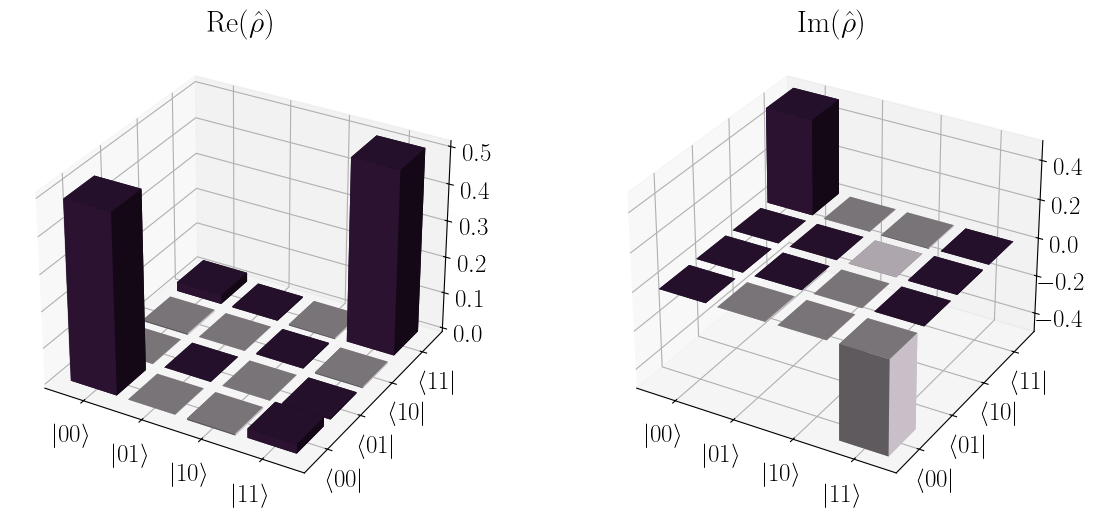

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_6214/2368986176.py:144: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


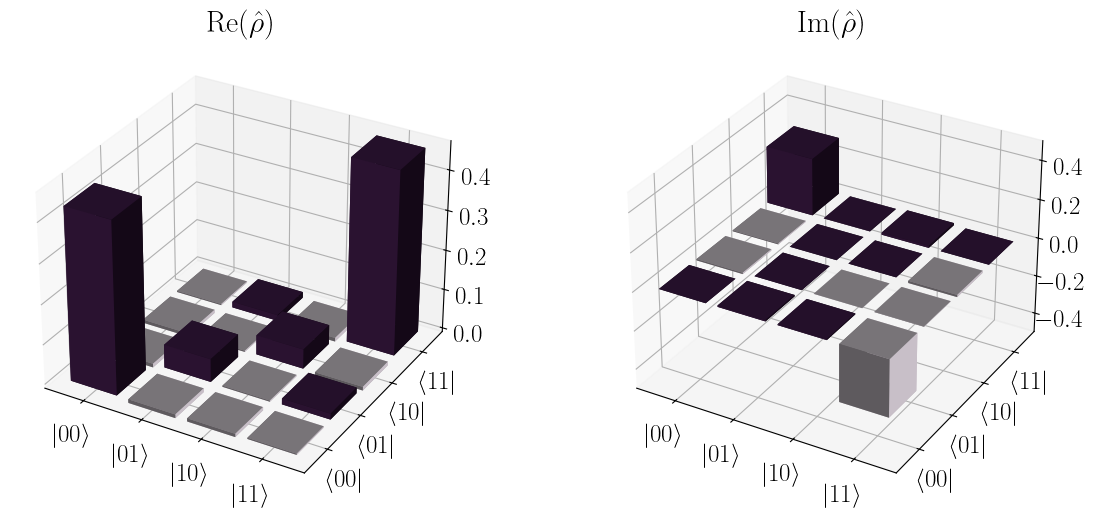

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_6214/2368986176.py:144: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


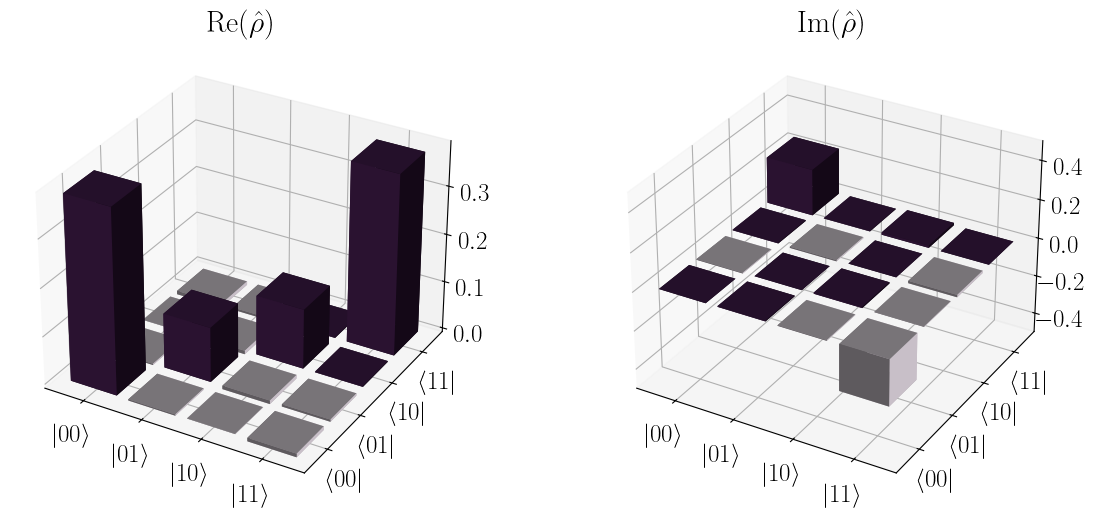

In [155]:

dens_ideal = read_density_matrix('data/density_matrix_ideal_False.csv')
plot_density_matrix(dens_ideal)

dens_depol = read_density_matrix('data/density_matrix_depol_True.csv')
plot_density_matrix(dens_depol)

dens_meas = read_density_matrix('data/density_matrix_meas_True.csv')
plot_density_matrix(dens_meas)


In [ ]:

# from math import pi
# num_qubits = 2
# gates = [qiskit.circuit.library.RXGate(i * pi / (num_qubits - 1))
#          for i in range(num_qubits)]

# subexps = [
#     StateTomography(gate, physical_qubits=(i,))
#     for i, gate in enumerate(gates)
# ]
# parexp = ParallelExperiment(subexps)
# pardata = parexp.run(backend, seed_simulation=100).block_for_results()

# for result in pardata.analysis_results():
#     print(result)

# # Backend
backend = AerSimulator()

gates = [qiskit.circuit.library.HGate(), qiskit.circuit.library.SGate(), qiskit.circuit.library.CXGate()]

# State tomography for each qubit
subexps = [
    StateTomography(gates[0], physical_qubits=(0, )), StateTomography(gates[1], physical_qubits=(1, ))#, StateTomography(gates[2], physical_qubits=(0, 1)),
]

# Parallel experiment
parexp = ParallelExperiment(subexps)

# Run the experiment
pardata = parexp.run(backend, seed_simulation=42).block_for_results()
print(pardata.analysis_results()[3])
# Extract the results
# for res in result.analysis_results():
#     print(res)

for i, expdata in enumerate(pardata.child_data()):
    state_result_i = expdata.analysis_results("state")
    fid_result_i = expdata.analysis_results("state_fidelity")

    print(f'\nPARALLEL EXP {i}')
    print("State Fidelity: {:.5f}".format(fid_result_i.value))
    print("State: {}".format(state_result_i.value))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


AnalysisResult
- name: state
- value: DensityMatrix([[ 9.99352760e-01+0.00000000e+00j,
                -1.36541770e-02-2.14565639e-02j],
               [-1.36541770e-02+2.14565639e-02j,
                 6.47239605e-04-2.52573691e-20j]],
              dims=(2,))
- quality: unknown
- extra: <9 items>
- device_components: ['Q1']
- verified: False
